In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

In [142]:
users = pd.read_csv(r'C:\Users\Evan\Desktop\relax_challenge\takehome_users.csv', encoding = 'latin-1', parse_dates=['creation_time'])
engagement = pd.read_csv(r'C:\Users\Evan\Desktop\relax_challenge\takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [143]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [144]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [145]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [146]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [147]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Identify which users are adopters and which are multi adopters and merge that info back into the users dataframe

In [148]:
engagement.set_index('time_stamp', inplace=True)

# Group by weekly intervals and count the number of logins for each user_id
weekly_visits = engagement.groupby([pd.Grouper(freq='1W'), 'user_id'])['visited'].count()

# Select only users who have logged in at least 3 times within a 1 week interval
adopters_df = pd.DataFrame(weekly_visits[weekly_visits >= 3])

# Swap the index levels and sort by user_id so that I can count how many times a user was an 'adopter'
adopters_df.swaplevel().sort_index(level=['user_id', 'time_stamp'], inplace=True)


# Get a count of how many times each user logged in at least 3 times within 1 week interval
times_adopted = pd.DataFrame(adopters_df.reset_index().groupby('user_id')['user_id'].count())
times_adopted.columns = ['times_adopted']

# Identify which users have multiple weeks where they were considered an 'adopter'
single_adopters = times_adopted.index[times_adopted['times_adopted'] == 1]
multi_adopters = times_adopted.index[times_adopted['times_adopted'] > 1]
all_adopters = times_adopted.index



In [149]:
# Make columns for 'adopter' and 'multi_adopter' in the users df
users['adopter'] = 0
users.loc[(users['object_id'].isin(list(all_adopters))), 'adopter'] = 1

users['multi_adopter'] = 0
users.loc[(users['object_id'].isin(list(multi_adopters))), 'multi_adopter'] = 1

### Feature Engineering

In [150]:
# Get list of users who have invited others and make 'has_invited_other' column in users df
users['counter'] = 1
users_who_invited = list(users.groupby(by='invited_by_user_id').count()['counter'].index)
users.drop('counter', axis=1)

users['has_invited_other'] = 0
users.loc[(users['object_id'].isin(users_who_invited)), 'has_invited_other'] = 1

# Make column 'num_invited' for the number of users a user has invited
# Assume than org_id 0 means user is not in an organization
users['num_invited'] = 0
for idx, user in enumerate(users['object_id']):
    if user in users_who_invited:
        users.loc[idx, 'num_invited'] = num_invites[user]

In [151]:
# Make column 'org_size' with the number of users in the user's organization
org_sizes = users.groupby(by='org_id').count()['counter']
users['org_size'] = 0
for idx, org in enumerate(users['org_id']):
    if org == 0:
        users.loc[idx, 'org_size'] = 0
    if org in org_sizes.index:
        users.loc[idx, 'org_size'] = org_sizes[org]

In [152]:
# Make column 'invited_by_multi_adopter' to signify whether a user was invited by a multi_adopter
users['invited_by_multi_adopter'] = 0
for idx, inviter in enumerate(users['invited_by_user_id']):
    if inviter in multi_adopters:
        users.loc[idx, 'invited_by_multi_adopter'] = 1

In [153]:
# Make column 'email_provider' to indicate which email provider the user used to sign up
def get_email(string):
    email = string.split('@')[1].split('.')[0]
    return email

users['email_provider'] = users['email'].apply(get_email)

In [154]:
users.tail(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopter,multi_adopter,counter,has_invited_other,num_invited,org_size,invited_by_multi_adopter,email_provider
11990,11991,2014-04-20 14:22:45,Vaughn Arthur,ArthurJVaughn@gmail.com,SIGNUP_GOOGLE_AUTH,2014-05-30 14:22:45,0,0,388,NaN,0,0,1,0,0,14,0,gmail
11991,11992,2014-04-09 19:39:56,Hermansen Amanda,AmandaAHermansen@yahoo.com,PERSONAL_PROJECTS,2014-04-11 19:39:56,0,0,129,NaN,0,0,1,0,0,28,0,yahoo
11992,11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaT,0,0,281,NaN,0,0,1,0,0,18,0,cuvox
11993,11994,2012-06-05 04:46:16,Grimstone Joel,conxzghp@eaouk.com,GUEST_INVITE,NaT,0,0,84,5450.0,0,0,1,1,7,40,0,eaouk
11994,11995,2013-10-21 13:33:17,Werfel Sebastian,SebastianWerfel@gmail.com,PERSONAL_PROJECTS,2013-10-22 13:33:17,0,0,0,NaN,0,0,1,0,0,319,0,gmail
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,0,0,1,0,0,40,0,gustr
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,0,0,1,1,1,25,0,gmail
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,0,0,1,0,0,27,0,cuvox
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0,0,1,1,7,138,0,iuxiw
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,2014-01-26 08:57:12,0,1,0,NaN,0,0,1,0,0,319,0,hotmail


### EDA

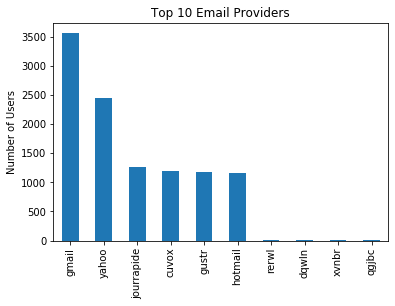

In [155]:
users.email_provider.value_counts()[0:10].plot(kind='bar')
plt.title('Top 10 Email Providers')
plt.ylabel('Number of Users')
plt.show()

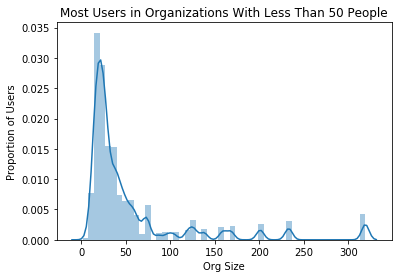

In [156]:
sns.distplot(users['org_size'])
plt.title('Most Users in Organizations With Less Than 50 People')
plt.ylabel('Proportion of Users')
plt.xlabel('Org Size')
plt.show()

### Adopters make up a small percentage of all users, but most adopters are multi adopters
* These are imbalanced classes

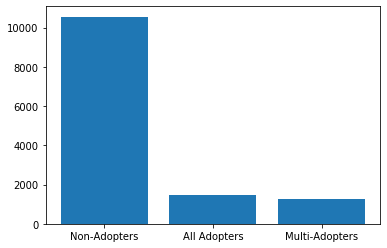

Non-adopters: 10555
Adopters: 1445
Multi-Adopters: 1250


In [157]:
data = users['adopter'].value_counts()
multi = users['multi_adopter'].value_counts()[1:]
data = data.append(multi, ignore_index=True)
data.index = ['Non-Adopters', 'All Adopters', 'Multi-Adopters']
plt.bar(data.index, data.values)
plt.show()

print('Non-adopters: {}'.format(data.values[0]))
print('Adopters: {}'.format(data.values[1]))
print('Multi-Adopters: {}'.format(data.values[2]))

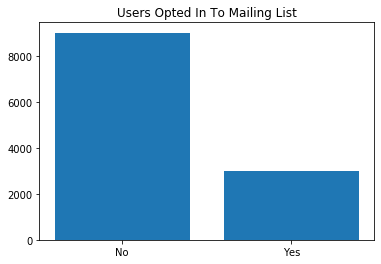

In [158]:
data = users['opted_in_to_mailing_list'].value_counts()
data.index = ['No', 'Yes']
plt.bar(data.index, data.values)
plt.title('Users Opted In To Mailing List')
plt.show()

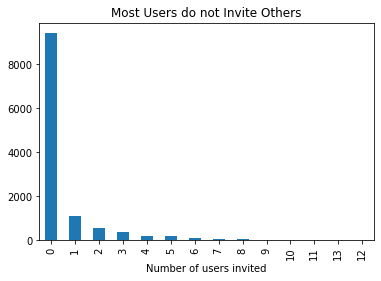

In [159]:
users['num_invited'].value_counts().plot(kind='bar')
plt.title('Most Users do not Invite Others')
plt.xlabel('Number of users invited')
plt.show()

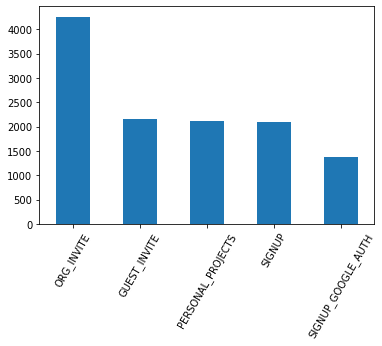

In [160]:
users['creation_source'].value_counts().plot(kind='bar')
plt.xticks(rotation=60)
plt.show()

### Build Models

In [161]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopter                     12000 non-null  int64         
 11  multi_adopter               12000 non-null  int64     

### Make Dummies

In [162]:
users = pd.concat([users, pd.get_dummies(users['creation_source'])], axis=1)

### Drop unneccesary columns

In [163]:
users_numeric = users.drop(labels = ['object_id', 'creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time',
                                     'invited_by_user_id', 'multi_adopter', 'counter', 'email_provider'], axis=1)

In [164]:
users_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    12000 non-null  int64
 1   enabled_for_marketing_drip  12000 non-null  int64
 2   org_id                      12000 non-null  int64
 3   adopter                     12000 non-null  int64
 4   has_invited_other           12000 non-null  int64
 5   num_invited                 12000 non-null  int64
 6   org_size                    12000 non-null  int64
 7   invited_by_multi_adopter    12000 non-null  int64
 8   GUEST_INVITE                12000 non-null  uint8
 9   ORG_INVITE                  12000 non-null  uint8
 10  PERSONAL_PROJECTS           12000 non-null  uint8
 11  SIGNUP                      12000 non-null  uint8
 12  SIGNUP_GOOGLE_AUTH          12000 non-null  uint8
dtypes: int64(8), uint8(5)
memory usage: 808.7 KB


### Scale and split the data into train/test

In [165]:
X = users_numeric.drop(labels=['adopter'], axis=1)
y = users['adopter']

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### 

In [191]:
model = TSNE(learning_rate = 500, random_state=42)
transformed = model.fit_transform(X)

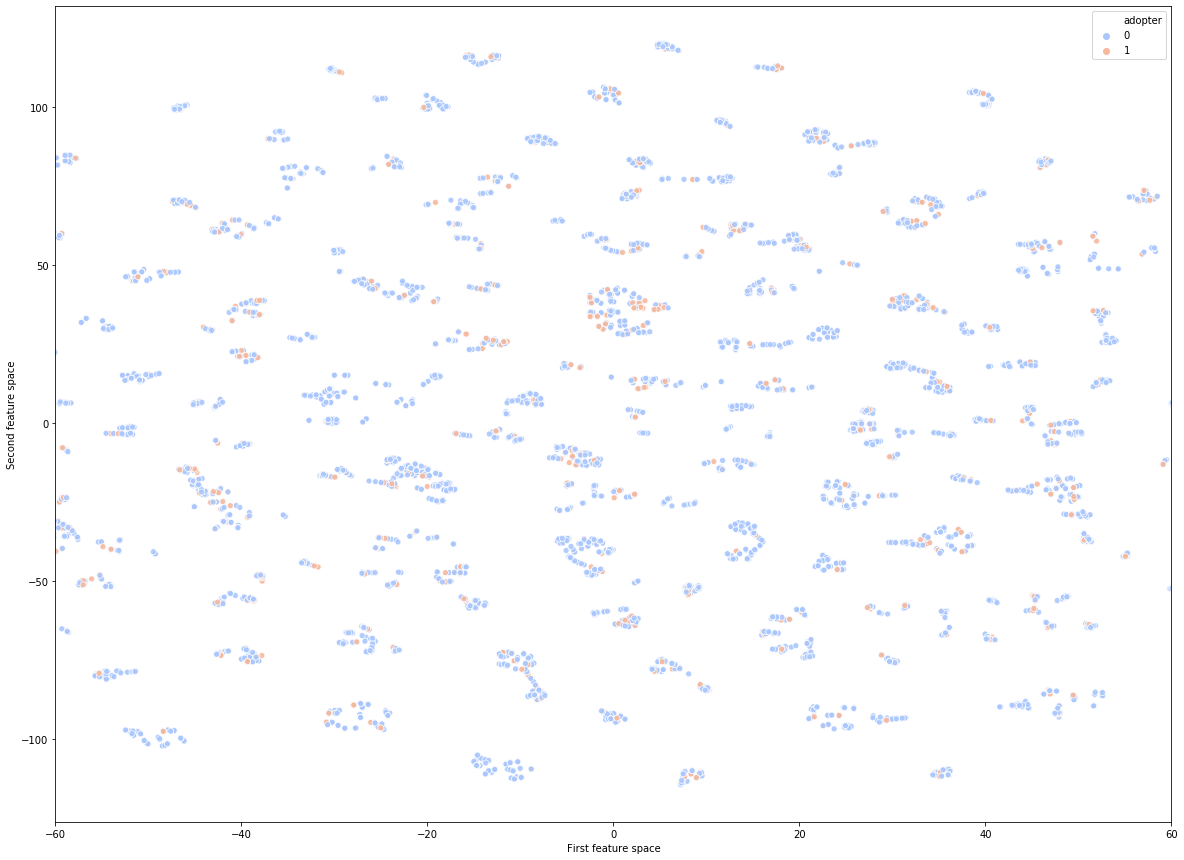

In [192]:
plt.rcParams["figure.figsize"] = (20,15)
xs = transformed[:,0]
ys = transformed[:,1]

sns.scatterplot(xs, ys, hue=y, palette='coolwarm', alpha=0.9)
plt.xlim(-60,60)
plt.xlabel('First feature space')
plt.ylabel('Second feature space')
plt.show()

### Gradient Boosting Classifier

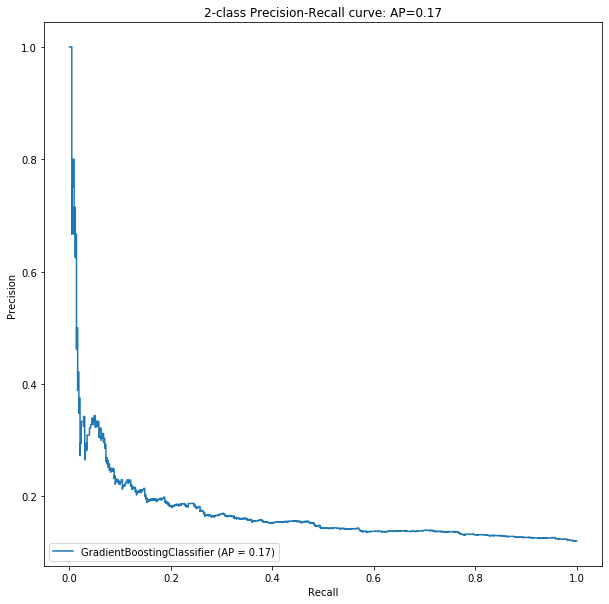

{'subsample': 0.6, 'n_estimators': 60, 'min_samples_split': 350, 'loss': 'exponential', 'learning_rate': 0.2}
Gradient Boosting Precision-Recall Score: 0.17


In [222]:
param_grid = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [60, 70, 80, 90, 100, 110, 120, 150, 200],
    'min_samples_split': [350],
    'subsample': [0.2, 0.4, 0.6, 0.8]
}

gb = GradientBoostingClassifier()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
gbc = RandomizedSearchCV(gb, param_distributions=param_grid, cv=cv, random_state=42, n_jobs=-1)

gbc.fit(X_train, y_train)

y_score = gbc.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

pr_disp = plot_precision_recall_curve(gbc.best_estimator_, X_test, y_test)
pr_disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()

print(gbc.best_params_)
print('Gradient Boosting Precision-Recall Score: {0:0.2f}'.format(average_precision))

In [211]:
y_pred

array([0.91196071, 0.08803929])

### Support Vector Classifier

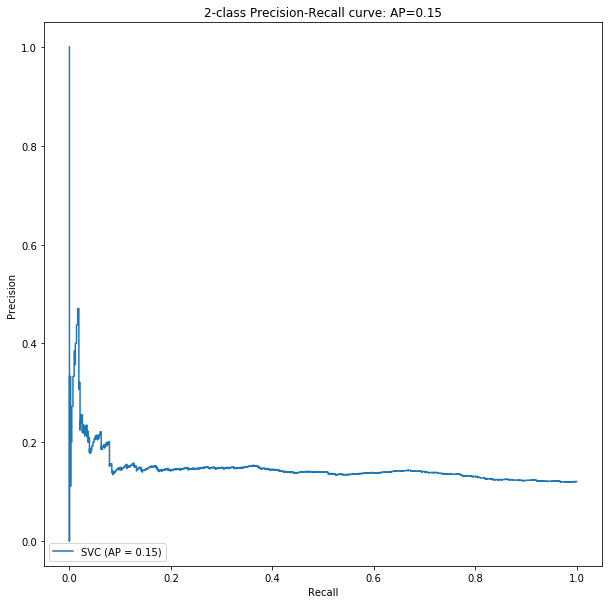

{'kernel': 'rbf', 'gamma': 'scale', 'C': 1000}
rbf_svc precision: 0.12987706939260454


In [223]:
svc = svm.SVC(class_weight='balanced', probability=True)

param_grid = [
      {'C': [0.5, 1, 10, 100, 1000], 
       'gamma': ['scale', 'auto', 0.001, 0.0001], 
       'kernel': ['rbf', 'poly', 'sigmoid'],
       }
 ]
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
rbf_svc = RandomizedSearchCV(svc, param_distributions=param_grid, cv=cv, random_state=42, n_jobs=-1)

rbf_svc.fit(X_train, y_train)

y_score = rbf_svc.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

pr_disp = plot_precision_recall_curve(rbf_svc.best_estimator_, X_test, y_test)
pr_disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()

print(rbf_svc.best_params_)
print('rbf_svc Average Precision: {}'.format(average_precision))

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

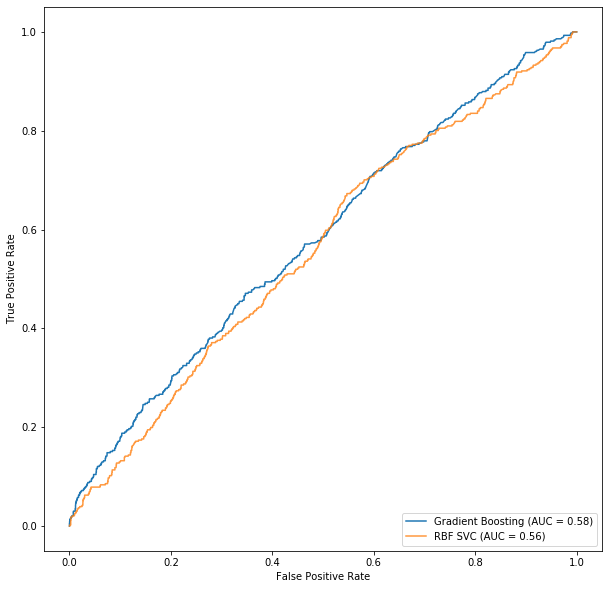

In [224]:
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

gbc_disp = plot_roc_curve(gbc, X_test, y_test, ax=ax, name='Gradient Boosting')
rbf_svc_disp = plot_roc_curve(rbf_svc, X_test, y_test, ax=ax, alpha=0.8, name='RBF SVC')

plt.show()

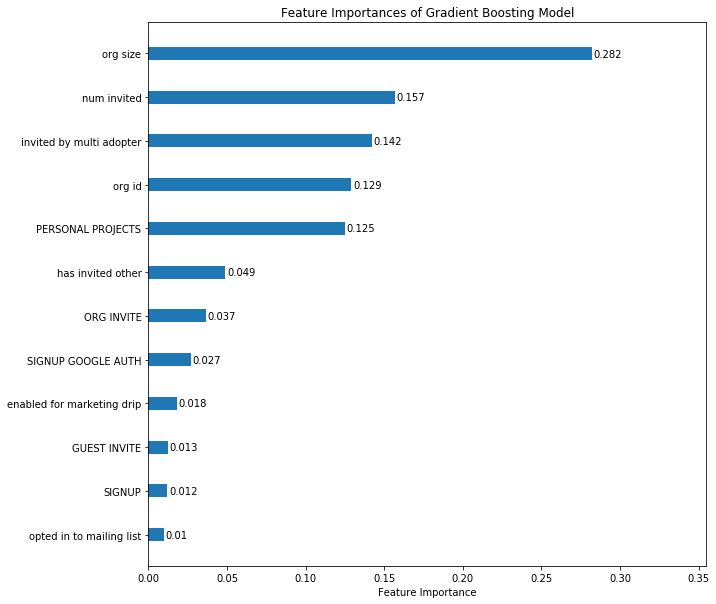

In [179]:
features = [sub.replace('_', ' ') for sub in X.columns]
importances = pd.DataFrame(list(zip(features, gbc.best_estimator_.feature_importances_)),
                              columns=['feature', 'importance'])
importances.sort_values(by='importance', ascending=True, inplace=True)

ax = plt.barh(importances.feature, importances.importance, height=0.3, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importances of Gradient Boosting Model')

for i in ax.patches:
    plt.text(i.get_width()+.001, i.get_y()+0.08, 
           str(round(i.get_width(),3)))
plt.xlim([0,.355])
plt.show()